In [1]:
# coding: utf-8
from typing import Dict, Optional

import pandas as pd
import plotly.express as px

from data.data_loader import PykrxDataLoader
from simulation.account import Account
from simulation.broker import Broker
from simulation.utility import get_lookback_fromdate
from simulation.utility import rebalance
from simulation.metric import cagr, mdd, sharpe_ratio, sortino_ratio

# 모멘텀 전략 정의하기

In [2]:
def calculate_momentum(ohlcv_data: pd.DataFrame,
                       lookback_period: int,
                       skip_period: int,
                       momentum: str) -> pd.DataFrame:
    # 종가 데이터 만들기
    data = ohlcv_data[['high', 'close', 'ticker']].reset_index().set_index(
        ['ticker', 'date']).unstack(level=0)
    close_data = data['close']

    # 모멘텀 계산하기
    if momentum == "returns":
        momentum_data = close_data.shift(periods=skip_period).rolling(
            window=lookback_period).apply(lambda x: x[-1] / x[0] - 1)
    elif momentum == '52wh':
        highest_highs = data['high'].shift(periods=skip_period).rolling(window=lookback_period).max()
        momentum_data = close_data.shift(periods=skip_period) / highest_highs
    else:
        raise ValueError

    return momentum_data


def get_momentum_weights(strategy_name: str,
                         momentum_data: pd.DataFrame,
                         buying_ratio: float,
                         buying_criteria: float) -> Optional[Dict]:
    # 1. 모멘텀 데이터 중 결측치가 있는지 확인함
    if momentum_data.isnull().values.any():
        return None

    # 2. 매수할 주식을 선정함
    if strategy_name == 'relative' or strategy_name == '52wh':
        top_quantile = momentum_data.quantile(1 - buying_ratio)
        stocks_to_buy = momentum_data[momentum_data >= top_quantile].index.to_list()
    elif strategy_name == 'absolute':
        stocks_to_buy = momentum_data[momentum_data > buying_criteria].index.to_list()
    elif strategy_name == 'dual':
        top_quantile = momentum_data.quantile(1 - buying_ratio)
        relative_result = set(momentum_data[momentum_data >= top_quantile].index)
        absolute_result = set(momentum_data[momentum_data > buying_criteria].index)
        stocks_to_buy = list(relative_result & absolute_result)
    else:
        raise ValueError

    # 3. 주식 비율을 할당함
    weights = 1 / len(stocks_to_buy) if stocks_to_buy else 0
    portfolio = {ticker: weights if ticker in stocks_to_buy else 
                 0.0 for ticker in momentum_data.index}

    return portfolio

# 모멘텀 전략을 이용한 시뮬레이션 함수 정의하기

In [3]:
def simulate_momentum(ohlcv_data: pd.DataFrame,
                      lookback_period: int,
                      skip_period: int,
                      strategy_name: str,
                      buying_ratio: float = 0.1,
                      buying_criteria: float = 0.0) -> Account:
    # 1. 계좌 및 브로커 선언
    account = Account(initial_cash=100000000)
    broker = Broker()

    # 2. 모멘텀 계산
    momentum = 'returns' if strategy_name != '52wh' else '52wh'
    momentum_data = calculate_momentum(ohlcv_data=ohlcv_data,
                                       lookback_period=lookback_period,
                                       skip_period=skip_period,
                                       momentum=momentum)

    for date, ohlcv in ohlcv_data.groupby(['date']):
        print(date.date())

        # 3. 주문 집행 및 계좌 갱신
        transactions = broker.process_order(dt=date, data=ohlcv, orders=account.orders)
        account.update_position(transactions=transactions)
        account.update_portfolio(dt=date, data=ohlcv)
        account.update_order()

        # 4. 모멘텀 전략을 이용하여 포트폴리오 구성
        momentum_data_slice = momentum_data.loc[date]
        weights = get_momentum_weights(strategy_name=strategy_name,
                                       momentum_data=momentum_data_slice,
                                       buying_ratio=buying_ratio,
                                       buying_criteria=buying_criteria)

        print(f'Portfolio: {weights}')
        if weights is None:
            continue

        # 5. 주문 생성
        rebalance(dt=date, data=ohlcv, account=account, weights=weights)

    return account

# 투자 기간 및 종목 정의하기

In [4]:
# 데이터 시작과 끝 날짜 정의
fromdate = '2018-07-10'
todate = '2023-09-27'

# 투자할 종목 후보 정의
ticker_list = ['005930', '000660', '207940',
               '051910', '006400', '005380',
               '000270', '005490', '035420']

## 상대모멘텀 전략 실행하기

In [5]:
# 룩백 기간 정의
lookback = 6

# 생략 기간 정의
offset = 1

# 기간을 고려한 데이터 시작 날짜 가져오기
adj_fromdate = get_lookback_fromdate(fromdate=fromdate, lookback=lookback+offset, freq='m')

# 데이터 불러오기
data_loader = PykrxDataLoader(fromdate=adj_fromdate, todate=todate, market="KOSPI")
ohlcv_data = data_loader.load_stock_data(ticker_list=ticker_list, freq='m', delay=1)

# 상위 N% 매수 비율 정의
ratio = 0.2

# 전략 정의
strategy = 'relative'  # {relative, absolute, dual, 52wh}

# 상대모멘텀 전략 실행하기
account_relative = simulate_momentum(ohlcv_data=ohlcv_data,
                                     lookback_period=lookback,
                                     skip_period=offset,
                                     strategy_name=strategy,
                                     buying_ratio=ratio)

2018-01-31
Portfolio: None
2018-02-28
Portfolio: None
2018-03-31
Portfolio: None
2018-04-30
Portfolio: None
2018-05-31
Portfolio: None
2018-06-30
Portfolio: None
2018-07-31
Portfolio: {'000270': 0.0, '000660': 0.5, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.5, '035420': 0.0, '051910': 0.0, '207940': 0.0}
2018-08-31
Portfolio: {'000270': 0.0, '000660': 0.5, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.5, '035420': 0.0, '051910': 0.0, '207940': 0.0}
2018-09-30
Portfolio: {'000270': 0.5, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.5, '035420': 0.0, '051910': 0.0, '207940': 0.0}
2018-10-31
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.5, '035420': 0.0, '051910': 0.0, '207940': 0.5}
2018-11-30
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.5, '035420': 0.0, '051910': 0.5, '207940': 0.0}
2018-12-31
Portfolio: {'000270': 0.5, '000660': 

## 중기모멘텀 전략 실행하기

In [6]:
# 룩백 기간 정의
lookback = 3

# 생략 기간 정의
offset = 6

# 기간을 고려한 데이터 시작 날짜 가져오기
adj_fromdate = get_lookback_fromdate(fromdate=fromdate, lookback=lookback+offset, freq='m')

# 데이터 불러오기
data_loader = PykrxDataLoader(fromdate=adj_fromdate, todate=todate, market="KOSPI")
ohlcv_data = data_loader.load_stock_data(ticker_list=ticker_list, freq='m', delay=1)

# 상위 N% 매수 비율 정의
ratio = 0.2

# 전략 정의
strategy = 'relative'  # {relative, absolute, dual, 52wh}

# 중기모멘텀 전략 실행하기
account_intermediate = simulate_momentum(ohlcv_data=ohlcv_data,
                                         lookback_period=lookback,
                                         skip_period=offset,
                                         strategy_name=strategy,
                                         buying_ratio=ratio)

2017-11-30
Portfolio: None
2017-12-31
Portfolio: None
2018-01-31
Portfolio: None
2018-02-28
Portfolio: None
2018-03-31
Portfolio: None
2018-04-30
Portfolio: None
2018-05-31
Portfolio: None
2018-06-30
Portfolio: None
2018-07-31
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.0, '035420': 0.5, '051910': 0.0, '207940': 0.5}
2018-08-31
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '005490': 0.5, '005930': 0.0, '006400': 0.0, '035420': 0.0, '051910': 0.0, '207940': 0.5}
2018-09-30
Portfolio: {'000270': 0.0, '000660': 0.5, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.0, '035420': 0.0, '051910': 0.0, '207940': 0.5}
2018-10-31
Portfolio: {'000270': 0.0, '000660': 0.5, '005380': 0.0, '005490': 0.0, '005930': 0.5, '006400': 0.0, '035420': 0.0, '051910': 0.0, '207940': 0.0}
2018-11-30
Portfolio: {'000270': 0.0, '000660': 0.5, '005380': 0.0, '005490': 0.5, '005930': 0.0, '006400': 0.0, '035420': 0.0, '051910': 0.0, '207940':

## 절대모멘텀 전략 실행하기

In [7]:
# 룩백 기간 정의
lookback = 6

# 생략 기간 정의
offset = 1

# 기간을 고려한 데이터 시작 날짜 가져오기
adj_fromdate = get_lookback_fromdate(fromdate=fromdate, lookback=lookback+offset, freq='m')

# 데이터 불러오기
data_loader = PykrxDataLoader(fromdate=adj_fromdate, todate=todate, market="KOSPI")
ohlcv_data = data_loader.load_stock_data(ticker_list=ticker_list, freq='m', delay=1)

# 매수 기준 정의
criteria = 0.0

# 전략 정의
strategy = 'absolute'  # {relative, absolute, dual, 52wh}

# 절모멘텀 전략 실행하기
account_absolute = simulate_momentum(ohlcv_data=ohlcv_data,
                                     lookback_period=lookback,
                                     skip_period=offset,
                                     strategy_name=strategy,
                                     buying_criteria=criteria)

2018-01-31
Portfolio: None
2018-02-28
Portfolio: None
2018-03-31
Portfolio: None
2018-04-30
Portfolio: None
2018-05-31
Portfolio: None
2018-06-30
Portfolio: None
2018-07-31
Portfolio: {'000270': 0.0, '000660': 0.5, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.5, '035420': 0.0, '051910': 0.0, '207940': 0.0}
2018-08-31
Portfolio: {'000270': 0.0, '000660': 0.5, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.5, '035420': 0.0, '051910': 0.0, '207940': 0.0}
2018-09-30
Portfolio: {'000270': 0.25, '000660': 0.25, '005380': 0.0, '005490': 0.25, '005930': 0.0, '006400': 0.25, '035420': 0.0, '051910': 0.0, '207940': 0.0}
2018-10-31
Portfolio: {'000270': 0.25, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.25, '035420': 0.0, '051910': 0.25, '207940': 0.25}
2018-11-30
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.5, '035420': 0.0, '051910': 0.5, '207940': 0.0}
2018-12-31
Portfolio: {'000270': 0.0, '0

## 듀얼모멘텀 전략 실행하기

In [8]:
# 룩백 기간 정의
lookback = 6

# 생략 기간 정의
offset = 1

# 기간을 고려한 데이터 시작 날짜 가져오기
adj_fromdate = get_lookback_fromdate(fromdate=fromdate, lookback=lookback+offset, freq='m')

# 데이터 불러오기
data_loader = PykrxDataLoader(fromdate=adj_fromdate, todate=todate, market="KOSPI")
ohlcv_data = data_loader.load_stock_data(ticker_list=ticker_list, freq='m', delay=1)

# 상위 N% 매수 비율 및 매수 기준 정의
ratio = 0.2
criteria = 0.0

# 전략 정의
strategy = 'dual'  # {relative, absolute, dual, 52wh}

# 듀얼모멘텀 전략 실행하기
account_dual = simulate_momentum(ohlcv_data=ohlcv_data,
                                 lookback_period=lookback,
                                 skip_period=offset,
                                 strategy_name=strategy,
                                 buying_ratio=ratio,
                                 buying_criteria=criteria)

2018-01-31
Portfolio: None
2018-02-28
Portfolio: None
2018-03-31
Portfolio: None
2018-04-30
Portfolio: None
2018-05-31
Portfolio: None
2018-06-30
Portfolio: None
2018-07-31
Portfolio: {'000270': 0.0, '000660': 0.5, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.5, '035420': 0.0, '051910': 0.0, '207940': 0.0}
2018-08-31
Portfolio: {'000270': 0.0, '000660': 0.5, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.5, '035420': 0.0, '051910': 0.0, '207940': 0.0}
2018-09-30
Portfolio: {'000270': 0.5, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.5, '035420': 0.0, '051910': 0.0, '207940': 0.0}
2018-10-31
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.5, '035420': 0.0, '051910': 0.0, '207940': 0.5}
2018-11-30
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.5, '035420': 0.0, '051910': 0.5, '207940': 0.0}
2018-12-31
Portfolio: {'000270': 0.0, '000660': 

## 52주 최고가 모멘텀 전략 실행하기

In [9]:
# 룩백 기간 (52주=1년=12개월), 생략 기간(0개월)
lookback = 12

# 생략 기간 정의
offset = 0

# 기간을 고려한 데이터 시작 날짜 가져오기
adj_fromdate = get_lookback_fromdate(fromdate=fromdate, lookback=lookback+offset, freq='m')

# 데이터 불러오기
data_loader = PykrxDataLoader(fromdate=adj_fromdate, todate=todate, market="KOSPI")
ohlcv_data = data_loader.load_stock_data(ticker_list=ticker_list, freq='m', delay=1)

# 매수 비율 정의
ratio = 0.2

# 전략 정의
strategy = '52wh'  # {relative, absolute, dual, 52wh}

# 52주 최고가 모멘텀 전략 실행하기
account_52wh = simulate_momentum(ohlcv_data=ohlcv_data,
                                 lookback_period=lookback,
                                 skip_period=offset,
                                 strategy_name=strategy,
                                 buying_ratio=ratio)

2017-08-31
Portfolio: None
2017-09-30
Portfolio: None
2017-10-31
Portfolio: None
2017-11-30
Portfolio: None
2017-12-31
Portfolio: None
2018-01-31
Portfolio: None
2018-02-28
Portfolio: None
2018-03-31
Portfolio: None
2018-04-30
Portfolio: None
2018-05-31
Portfolio: None
2018-06-30
Portfolio: None
2018-07-31
Portfolio: {'000270': 0.0, '000660': 0.5, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.5, '035420': 0.0, '051910': 0.0, '207940': 0.0}
2018-08-31
Portfolio: {'000270': 0.5, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.5, '035420': 0.0, '051910': 0.0, '207940': 0.0}
2018-09-30
Portfolio: {'000270': 0.5, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.5, '035420': 0.0, '051910': 0.0, '207940': 0.0}
2018-10-31
Portfolio: {'000270': 0.5, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.5, '035420': 0.0, '051910': 0.0, '207940': 0.0}
2018-11-30
Portfolio: {'000270': 0.5, '000660': 0.0, '005380': 0.0, '00

# 투자 결과 분석 하기

In [10]:
rel_account = pd.DataFrame(account_relative.account_history).set_index('date')
rel_portfolio = pd.DataFrame(account_relative.portfolio_history).set_index('date')

inter_account = pd.DataFrame(account_intermediate.account_history).set_index('date')
inter_portfolio = pd.DataFrame(account_intermediate.portfolio_history).set_index('date')

abs_account = pd.DataFrame(account_absolute.account_history).set_index('date')
abs_portfolio = pd.DataFrame(account_absolute.portfolio_history).set_index('date')

dual_account = pd.DataFrame(account_dual.account_history).set_index('date')
dual_portfolio = pd.DataFrame(account_dual.portfolio_history).set_index('date')

wh52_account = pd.DataFrame(account_52wh.account_history).set_index('date')
wh52_portfolio = pd.DataFrame(account_52wh.portfolio_history).set_index('date')

In [11]:
relative_returns = rel_account['total_asset'].pct_change().loc[fromdate:]
relative_returns.name = 'relative_returns'
relative_returns.head()

date
2018-07-31    0.000000
2018-08-31   -0.004910
2018-09-30   -0.011872
2018-10-31   -0.134244
2018-11-30   -0.132186
Name: relative_returns, dtype: float64

In [12]:
intermediate_returns = inter_account['total_asset'].pct_change().loc[fromdate:]
intermediate_returns.name = 'intermediate_returns'
intermediate_returns.head()

date
2018-07-31    0.000000
2018-08-31    0.141086
2018-09-30    0.032969
2018-10-31   -0.176462
2018-11-30    0.003226
Name: intermediate_returns, dtype: float64

In [13]:
absolute_returns = abs_account['total_asset'].pct_change().loc[fromdate:]
absolute_returns.name = 'absolute_returns'
absolute_returns.head()

date
2018-07-31    0.000000
2018-08-31   -0.004910
2018-09-30   -0.011872
2018-10-31   -0.116342
2018-11-30   -0.042063
Name: absolute_returns, dtype: float64

In [14]:
dual_returns = dual_account['total_asset'].pct_change().loc[fromdate:]
dual_returns.name = 'dual_returns'
dual_returns.head()

date
2018-07-31    0.000000
2018-08-31   -0.004910
2018-09-30   -0.011872
2018-10-31   -0.134244
2018-11-30   -0.132186
Name: dual_returns, dtype: float64

In [15]:
wh52_returns = wh52_account['total_asset'].pct_change().loc[fromdate:]
wh52_returns.name = 'wh52_returns'
wh52_returns.head()

date
2018-07-31    0.000000
2018-08-31   -0.004910
2018-09-30    0.091664
2018-10-31   -0.139877
2018-11-30   -0.023959
Name: wh52_returns, dtype: float64

In [16]:
kospi = data_loader.load_index_data(ticker_list=['1001'], freq='m', delay=1)
kospi_returns = kospi['close'].pct_change().loc[fromdate:]
kospi_returns.iloc[0] = 0.0
kospi_returns.name = 'kospi_return'
kospi_returns.index.name = 'date'
kospi_returns.head()

date
2018-07-31    0.000000
2018-08-31    0.012033
2018-09-30    0.008692
2018-10-31   -0.133748
2018-11-30    0.033094
Freq: M, Name: kospi_return, dtype: float64

## CAGR

In [17]:
print(cagr(returns=relative_returns, freq='m'))
print(cagr(returns=intermediate_returns, freq='m'))
print(cagr(returns=absolute_returns, freq='m'))
print(cagr(returns=dual_returns, freq='m'))
print(cagr(returns=wh52_returns, freq='m'))
print(cagr(returns=kospi_returns, freq='m'))

0.039448919474234456
0.1469109285254584
0.08325681033348631
0.028496433557728684
0.15918876390733439
0.01368789551313876


## MDD

In [18]:
print(mdd(returns=relative_returns))
print(mdd(returns=intermediate_returns))
print(mdd(returns=absolute_returns))
print(mdd(returns=dual_returns))
print(mdd(returns=wh52_returns))
print(mdd(returns=kospi_returns))

-0.5051905266735592
-0.35532057764390734
-0.5186659221105427
-0.5236644336296543
-0.5478939058258154
-0.34616341288811775


## 샤프비율

In [19]:
print(sharpe_ratio(returns=relative_returns, freq='m'))
print(sharpe_ratio(returns=intermediate_returns, freq='m'))
print(sharpe_ratio(returns=absolute_returns, freq='m'))
print(sharpe_ratio(returns=dual_returns, freq='m'))
print(sharpe_ratio(returns=wh52_returns, freq='m'))
print(sharpe_ratio(returns=kospi_returns, freq='m'))

0.2735218662940373
0.5607470382949474
0.4314393781774359
0.24057504778509986
0.6442402345895699
0.1681266022723572


## 소티노비율

In [20]:
print(sortino_ratio(returns=relative_returns, freq='m'))
print(sortino_ratio(returns=intermediate_returns, freq='m'))
print(sortino_ratio(returns=absolute_returns, freq='m'))
print(sortino_ratio(returns=dual_returns, freq='m'))
print(sortino_ratio(returns=wh52_returns, freq='m'))
print(sortino_ratio(returns=kospi_returns, freq='m'))

0.32714625472095343
0.6457697977568708
0.47120429667404096
0.28679990951931233
0.7460707151965547
0.14972510403330058


## 누적 수익률

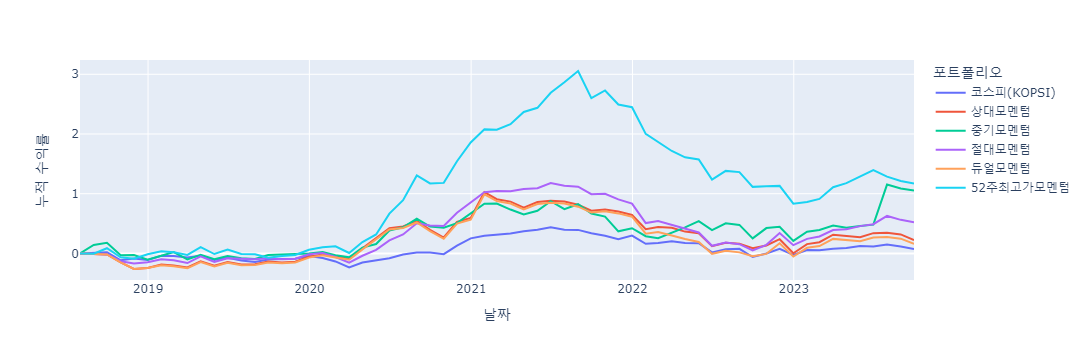

In [22]:
# 누적 수익률 계산하기
benchmark_cum_returns = (kospi_returns + 1).cumprod() - 1
relative_cum_returns = (relative_returns + 1).cumprod() - 1
intermediate_cum_returns = (intermediate_returns + 1).cumprod() - 1
absolute_cum_returns = (absolute_returns + 1).cumprod() - 1
dual_cum_returns = (dual_returns + 1).cumprod() - 1
wh52_cum_returns = (wh52_returns + 1).cumprod() - 1

# 자산 정보 결합하기
cum_returns = pd.concat([benchmark_cum_returns, relative_cum_returns, intermediate_cum_returns,
                         absolute_cum_returns, dual_cum_returns, wh52_cum_returns], axis=1)
cum_returns.columns = ["코스피(KOPSI)", "상대모멘텀", "중기모멘텀", "절대모멘텀",
                      "듀얼모멘텀", "52주최고가모멘텀"]

# 자산 변화 시각화하기
fig = px.line(data_frame=cum_returns)

# x축, y축 레이블 설정
fig.update_xaxes(title_text='날짜')
fig.update_yaxes(title_text='누적 수익률')

# 범례 제목 설정
fig.update_layout(legend_title_text='포트폴리오') 

fig.show()